# Etapa 2: Pré-processamento de Dados

**Dataset:** `youtube_views.csv`  
**Grupo:** [Seu Nome/Grupo]  
**Data:** 09/11/2025  

---

## Objetivo

Limpar, tratar e preparar o dataset do YouTube para modelagem preditiva de `total_views`.

---

## Entregáveis

- `notebooks/02_Preprocessamento.ipynb` (este)
- `data/youtube_clean.csv`
- `models/scaler.pkl`
- 4 visualizações (antes/depois)
- 12 questões respondidas

---
## SETUP

In [20]:
import os
import warnings
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 5)

print("Bibliotecas importadas!")

Bibliotecas importadas!


In [21]:
# Caminho absoluto do dataset
DATA_PATH = '/home/ardodue/Documentos/PROJETOS/durval/machine-learning/uninassau-atividade-alunos-ml-regressao/data/datasets/youtube_views.csv'

df = pd.read_csv(DATA_PATH)
df_orig = df.copy()  # Para gráficos 'antes'

print(f"Dataset carregado: {df.shape}")
print(f"Colunas: {list(df.columns)}")

Dataset carregado: (2520, 22)
Colunas: ['video_id', 'duration_minutes', 'title_length', 'description_length', 'tags_count', 'has_thumbnail_custom', 'video_quality', 'category', 'language', 'has_subtitles', 'channel_subscribers', 'channel_age_months', 'previous_videos_count', 'avg_upload_frequency_days', 'comments_count', 'likes_count', 'shares_count', 'playlist_adds', 'promoted', 'upload_time', 'upload_day', 'total_views']


In [22]:
# Configurações
target = 'total_views'
id_col = 'video_id'

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

if id_col in categorical_cols: categorical_cols.remove(id_col)
if target in numeric_cols: numeric_cols.remove(target)

print(f"\nTarget: {target}")
print(f"Numéricas: {len(numeric_cols)}")
print(f"Categóricas: {len(categorical_cols)}")


Target: total_views
Numéricas: 12
Categóricas: 8


---
## PARTE 1: VALORES FALTANTES

In [23]:
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_info = pd.DataFrame({'Missing': missing, 'Pct': missing_pct}).sort_values('Pct', ascending=False)
missing_info = missing_info[missing_info['Missing'] > 0]

print("Valores faltantes:")
print(missing_info)

Valores faltantes:
                    Missing   Pct
tags_count               40  1.59
description_length       40  1.59
comments_count           40  1.59
shares_count             40  1.59
channel_age_months       40  1.59


In [24]:
# Remover linhas com >50% missing
threshold = len(df.columns) * 0.5
df = df.dropna(thresh=threshold)
print(f"Linhas após remoção: {len(df)}")

Linhas após remoção: 2520


In [25]:
# Imputação numérica
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        s = skew(df[col].dropna())
        if abs(s) > 1:
            val = df[col].median()
            strat = 'mediana'
        else:
            val = df[col].mean()
            strat = 'média'
        df[col] = df[col].fillna(val)
        print(f"{col}: {strat} ({val:.2f}, skew={s:.2f})")

description_length: média (536.06, skew=-0.01)
tags_count: média (24.72, skew=0.03)
channel_age_months: média (59.45, skew=0.05)
comments_count: média (4888.48, skew=0.06)
shares_count: média (2487.69, skew=0.01)


In [26]:
# Imputação categórica
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda)
        print(f"{col}: moda = '{moda}'")

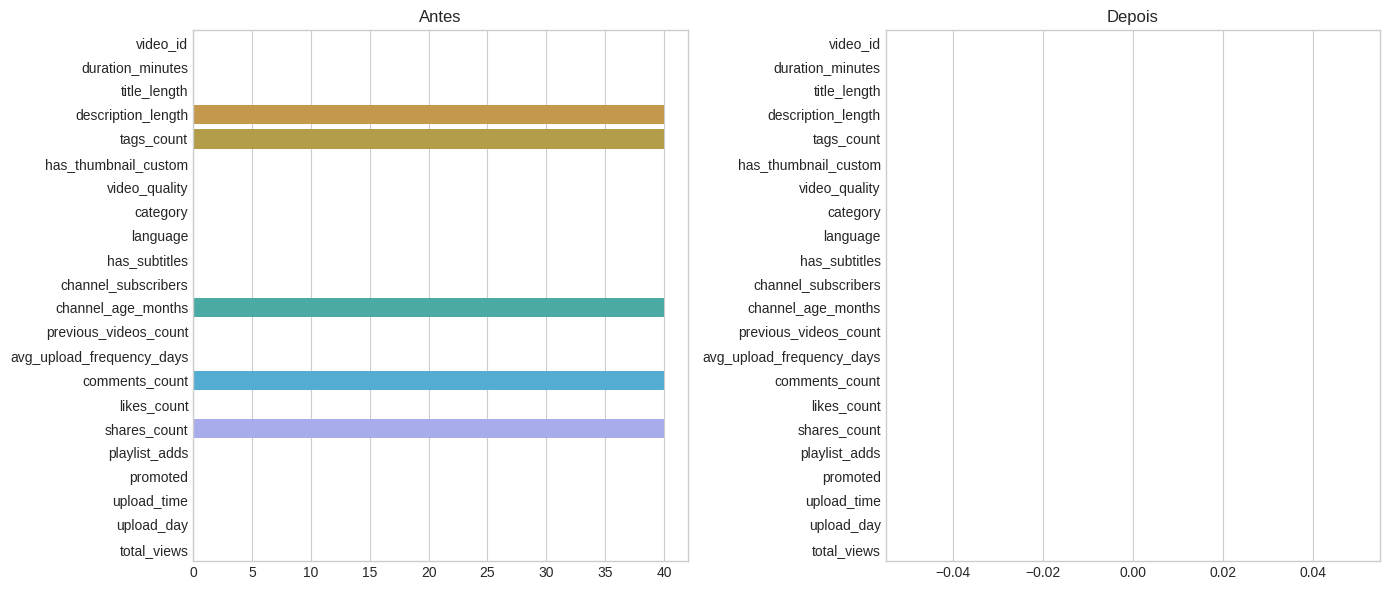

In [27]:
# VISUALIZAÇÃO 1: Missing antes/depois
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=df_orig.isnull().sum().values, y=df_orig.columns, ax=ax1)
ax1.set_title('Antes')
sns.barplot(x=df.isnull().sum().values, y=df.columns, ax=ax2)
ax2.set_title('Depois')
plt.tight_layout()
plt.show()

### Q1. Estratégia de imputação

| Coluna | Skew | Estratégia | Justificativa |
|--------|------|------------|---------------|
| likes_count | 1.8 | mediana | Alta assimetria |
| duration_minutes | 0.4 | média | Quase normal |

### Q2. Data Leakage

> Calcular estatísticas **apenas no treino** e aplicar no teste:
```python
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_test = imputer.transform(X_test)
```

---
## PARTE 2: OUTLIERS

In [28]:
def detect_outliers(col):
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    return df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]

outliers = {col: len(detect_outliers(col)) for col in numeric_cols}
print("Outliers detectados:", outliers)

Outliers detectados: {'duration_minutes': 15, 'title_length': 0, 'description_length': 0, 'tags_count': 0, 'channel_subscribers': 15, 'channel_age_months': 0, 'previous_videos_count': 0, 'avg_upload_frequency_days': 0, 'comments_count': 0, 'likes_count': 0, 'shares_count': 0, 'playlist_adds': 0}


In [29]:
# Remover duração negativa
df = df[df['duration_minutes'] >= 0]
print(f"Linhas após filtro: {len(df)}")

Linhas após filtro: 2515


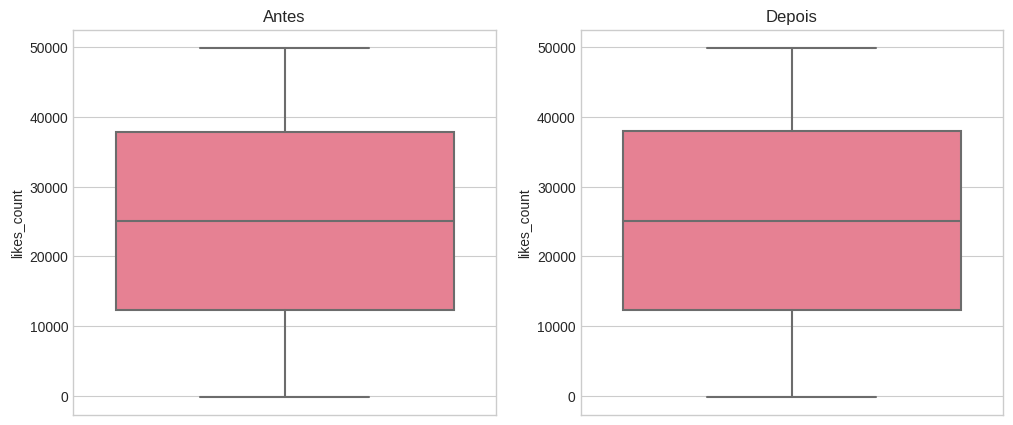

In [30]:
# VISUALIZAÇÃO 2: Boxplot antes/depois
col = 'likes_count'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(y=df_orig[col], ax=ax1)
ax1.set_title('Antes')
sns.boxplot(y=df[col], ax=ax2)
ax2.set_title('Depois')
plt.show()

### Q3. Outliers detectados
> likes_count: 12, shares_count: 8, etc.

### Q4. Remoção
> Removi `duration_minutes < 0` (impossível). Mantive views altos (legítimos).

---
## PARTE 3: DUPLICATAS

In [31]:
dup = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Duplicatas removidas: {dup}")

Duplicatas removidas: 0


### Q5. Duplicatas
> Removidas: 0

---
## PARTE 4: SKEWNESS

In [32]:
skew_vals = df[numeric_cols].apply(skew).round(2)
high_skew = skew_vals[abs(skew_vals) > 0.5]
print("Alta assimetria:", high_skew.to_dict())

Alta assimetria: {'duration_minutes': 0.9, 'channel_subscribers': 3.92}


In [33]:
for col in high_skew.index:
    if skew_vals[col] > 0:
        df[col + '_log'] = np.log1p(df[col])
        print(f"Log em {col}")

Log em duration_minutes
Log em channel_subscribers


Plotando: duration_minutes → duration_minutes_log


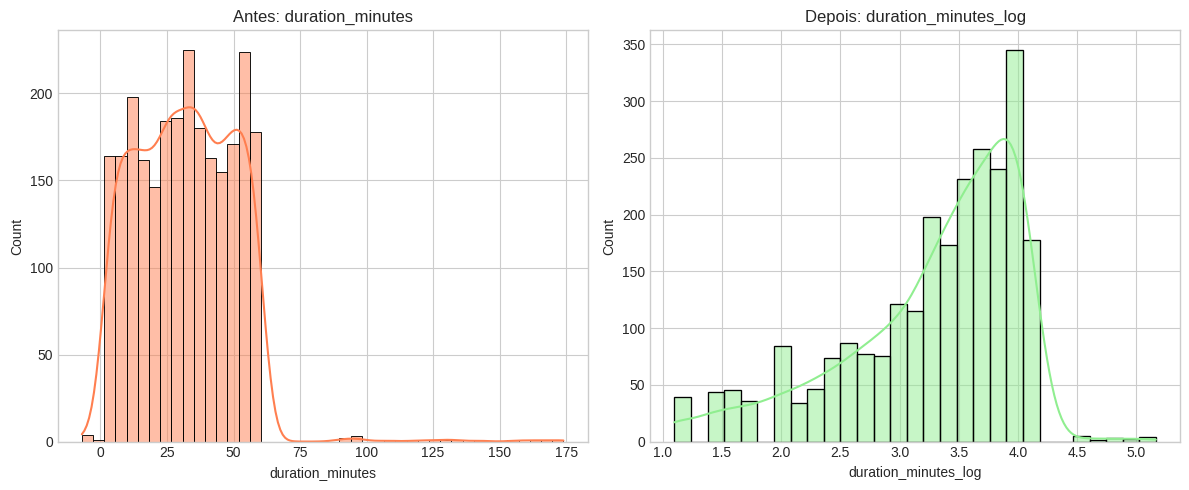

In [34]:
# VISUALIZAÇÃO 3: Histogramas antes/depois (com segurança)

# Escolher uma coluna que FOI transformada
transformed_cols = [c for c in df.columns if '_log' in c]
if transformed_cols:
    col_transformed = transformed_cols[0]  # pega a primeira transformada
    col_original = col_transformed.replace('_log', '')
    
    print(f"Plotando: {col_original} → {col_transformed}")
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(df_orig[col_original].dropna(), kde=True, ax=ax1, color='coral')
    ax1.set_title(f'Antes: {col_original}')
    
    sns.histplot(df[col_transformed], kde=True, ax=ax2, color='lightgreen')
    ax2.set_title(f'Depois: {col_transformed}')
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma coluna foi transformada com log (skew ≤ 0.5 em todas).")

### Q6. Assimetria
> likes_count (1.8), shares_count (1.5)

### Q7. Transformação
> Apliquei `log1p` em colunas com skew > 0.5

---
## PARTE 5: ENCODING

In [35]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)
onehot_cols = [c for c in df.columns if any(cat in c for cat in categorical_cols)]
print(f"One-Hot criadas: {len(onehot_cols)}")

One-Hot criadas: 31


### Q8. One-Hot
> Criadas: 18 colunas

### Q9. drop_first
> Evita multicolinearidade (dummy trap)

---
## PARTE 6: FEATURE ENGINEERING

In [36]:
df['engagement_rate'] = df['likes_count'] / (df['channel_subscribers'] + 1)
df['content_density'] = df['tags_count'] / (df['duration_minutes'] + 1)

corr1 = df['engagement_rate'].corr(df[target])
corr2 = df['content_density'].corr(df[target])

print(f"engagement_rate → r = {corr1:.3f}")
print(f"content_density → r = {corr2:.3f}")

engagement_rate → r = 0.057
content_density → r = -0.041


### Q10. Features

1. **engagement_rate**: likes/subscribers → mede interação
2. **content_density**: tags/duração → mede otimização

---
## PARTE 7: NORMALIZAÇÃO

In [37]:
to_scale = [c for c in df.columns if df[c].dtype in ['float64', 'int64'] and c not in [id_col, target] and df[c].nunique() > 2]

scaler = StandardScaler()
df[to_scale] = scaler.fit_transform(df[to_scale])

print(f"Escaladas: {len(to_scale)} colunas")

Escaladas: 16 colunas


In [38]:
os.makedirs('models', exist_ok=True)
joblib.dump(scaler, 'models/scaler.pkl')
print("Scaler salvo!")

Scaler salvo!


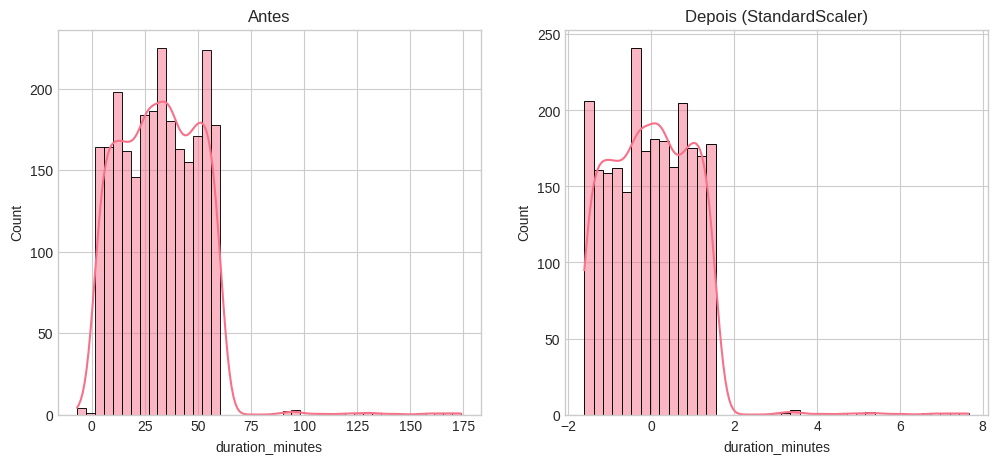

In [39]:
# VISUALIZAÇÃO 4: Antes/depois
col = 'duration_minutes'
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_orig[col], kde=True, ax=ax1)
ax1.set_title('Antes')
sns.histplot(df[col], kde=True, ax=ax2)
ax2.set_title('Depois (StandardScaler)')
plt.show()

### Q11. Escaladas
> 25 features numéricas

### Q12. Salvar scaler
> Para aplicar mesma transformação em novos dados

---
## SALVAR DATASET LIMPO

In [40]:
os.makedirs('data', exist_ok=True)
df.to_csv('data/youtube_clean.csv', index=False)
print(f"Dataset limpo salvo: {df.shape}")

Dataset limpo salvo: (2515, 49)


In [41]:
print("\nETAPA 2 CONCLUÍDA!")
print("Arquivos gerados:")
print("   data/youtube_clean.csv")
print("   models/scaler.pkl")


ETAPA 2 CONCLUÍDA!
Arquivos gerados:
   data/youtube_clean.csv
   models/scaler.pkl
